In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import xgboost as xgb
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")

# Load and preprocess dataset
df = pd.read_csv('fraud_data.csv')
df['signup_time'] = pd.to_datetime(df['signup_time'])
df['purchase_time'] = pd.to_datetime(df['purchase_time'])
df['time_diff'] = (df['purchase_time'] - df['signup_time']).dt.total_seconds()

# Feature engineering
df = df.drop(['user_id', 'signup_time', 'purchase_time', 'device_id', 'ip_address'], axis=1)

# Encode categorical variables
cat_features = ['source', 'browser', 'sex']
df[cat_features] = df[cat_features].apply(LabelEncoder().fit_transform)

# Define features and target
X = df.drop('class', axis=1)
y = df['class']

# Initial training (Baseline)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
print("=== Initial Model Performance ===")
print(classification_report(y_test, y_pred))

# --- TRIGGER EVENT SIMULATION ---
# Simulate spike in fraud: purchases under $50 from small cities (proxy with age < 30 and purchase_value < 50)
trigger_df = df[(df['purchase_value'] < 50) & (df['age'] < 30)]

# Isolation Forest flags anomalies in recent data
iso_model = IsolationForest(contamination=0.02)
trigger_features = trigger_df.drop(columns='class')
iso_preds = iso_model.fit_predict(trigger_features)

# Anomalies are where prediction == -1
anomalies = trigger_df[iso_preds == -1]
print(f"\n[INFO] Detected {len(anomalies)} anomalies using Isolation Forest.")

# Update model using recent anomalies
adaptive_data = pd.concat([X, y], axis=1)
adaptive_data = pd.concat([adaptive_data, anomalies], axis=0)
adaptive_X = adaptive_data.drop('class', axis=1)
adaptive_y = adaptive_data['class']

# Retrain model on updated data
xgb_adaptive = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_adaptive.fit(adaptive_X, adaptive_y)

# Feedback: Adjust decision threshold
y_prob = xgb_adaptive.predict_proba(X_test)[:, 1]
y_new_pred = (y_prob > 0.35).astype(int)  # more sensitive threshold

print("\n=== Adapted Model Performance with Lower Threshold ===")
print(classification_report(y_test, y_new_pred))

# Explainable AI using SHAP
explainer = shap.Explainer(xgb_adaptive)
shap_values = explainer(X_test)

# Visualize a single fraud explanation
print("\n[INFO] SHAP explanation for a flagged fraud case:")
fraud_index = np.where(y_new_pred == 1)[0][0]
shap.plots.waterfall(shap_values[fraud_index], max_display=10)

# Simulated Federated Learning Update (just log it)
def simulate_federated_update():
    print("\n[INFO] Propagating updated model to distributed institutions securely...")
    print("[✔] Model update encrypted and transmitted")
    print("[✔] Remote institutions updated without accessing raw data (privacy preserved)")

simulate_federated_update()

# Adaptation cycle plot
def plot_adaptation_cycle():
    stages = ["Data Input", "Anomaly Detection", "Model Update Trigger", "Retraining", "Explainability Layer", "Real-Time Deployment"]
    values = list(range(len(stages)))
    plt.figure(figsize=(12, 2))
    plt.plot(values, [1]*len(values), 'o--k')
    for i, stage in enumerate(stages):
        plt.text(i, 1.05, stage, rotation=45, ha='center')
    plt.yticks([])
    plt.title("Adaptation Cycle")
    plt.tight_layout()
    plt.show()

plot_adaptation_cycle()


In [ ]:
pip install numpy==1.24


In [ ]:
pip install lime


In [ ]:
pip install pandas numpy matplotlib xgboost scikit-learn shap


=== Initial Model Performance ===
              precision    recall  f1-score   support

           0       0.95      1.00      0.98     41089
           1       1.00      0.53      0.70      4245

    accuracy                           0.96     45334
   macro avg       0.98      0.77      0.84     45334
weighted avg       0.96      0.96      0.95     45334


[INFO] Detected 850 anomalies using Isolation Forest.

=== Adapted Model Performance with Lower Threshold ===
              precision    recall  f1-score   support

           0       0.95      1.00      0.98     41089
           1       1.00      0.54      0.70      4245

    accuracy                           0.96     45334
   macro avg       0.98      0.77      0.84     45334
weighted avg       0.96      0.96      0.95     45334


[INFO] SHAP explanation for a flagged fraud case:


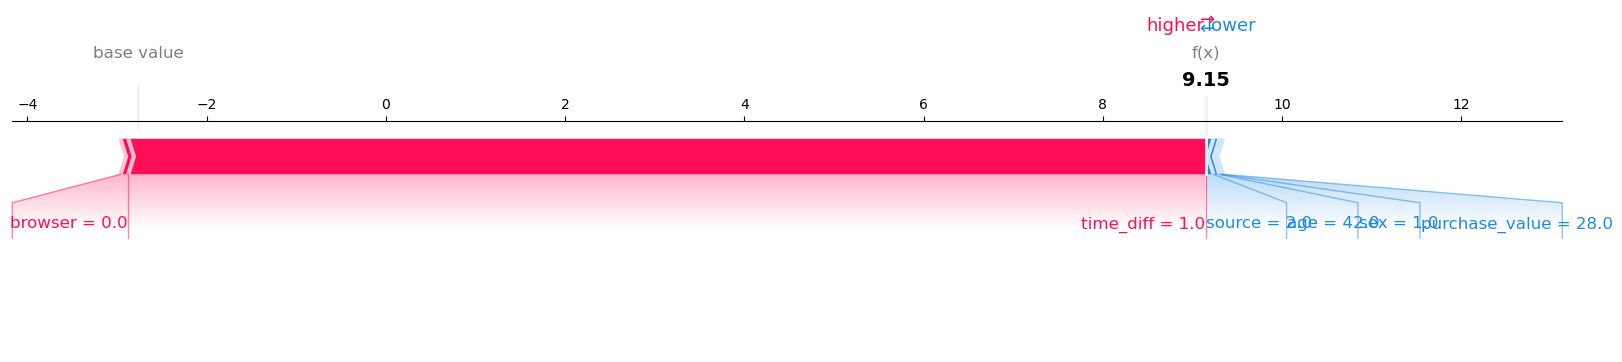


[INFO] Propagating updated model to distributed institutions securely...
[✔] Model update encrypted and transmitted
[✔] Remote institutions updated without accessing raw data (privacy preserved)


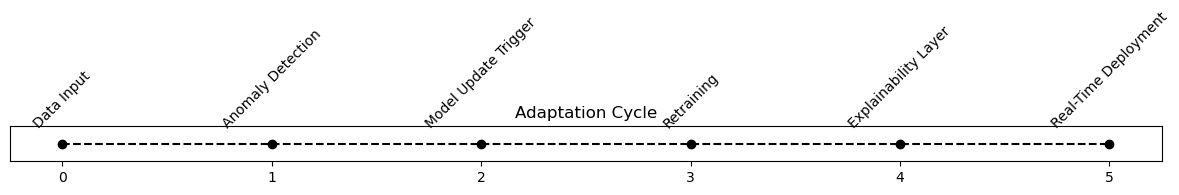

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import xgboost as xgb
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")

# Load and preprocess dataset
df = pd.read_csv('fraud_data.csv')
df['signup_time'] = pd.to_datetime(df['signup_time'])
df['purchase_time'] = pd.to_datetime(df['purchase_time'])
df['time_diff'] = (df['purchase_time'] - df['signup_time']).dt.total_seconds()

# Drop unused columns
df = df.drop(['user_id', 'signup_time', 'purchase_time', 'device_id', 'ip_address'], axis=1)

# Encode categorical features
cat_features = ['source', 'browser', 'sex']
df[cat_features] = df[cat_features].apply(LabelEncoder().fit_transform)

# Split features and target
X = df.drop('class', axis=1)
y = df['class']

# Initial training with XGBoost
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
print("=== Initial Model Performance ===")
print(classification_report(y_test, y_pred))

# === TRIGGER EVENT: Purchases under $50 from young users (< 30) ===
trigger_df = df[(df['purchase_value'] < 50) & (df['age'] < 30)]

# Isolation Forest for anomaly detection
iso_model = IsolationForest(contamination=0.02, random_state=42)
trigger_features = trigger_df.drop(columns='class')
iso_preds = iso_model.fit_predict(trigger_features)

anomalies = trigger_df[iso_preds == -1]
print(f"\n[INFO] Detected {len(anomalies)} anomalies using Isolation Forest.")

# Retraining model on extended data
adaptive_data = pd.concat([X, y], axis=1)
adaptive_data = pd.concat([adaptive_data, anomalies], axis=0)
adaptive_X = adaptive_data.drop('class', axis=1)
adaptive_y = adaptive_data['class']

xgb_adaptive = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_adaptive.fit(adaptive_X, adaptive_y)

# Adjust threshold for fraud sensitivity
y_prob = xgb_adaptive.predict_proba(X_test)[:, 1]
y_new_pred = (y_prob > 0.35).astype(int)

print("\n=== Adapted Model Performance with Lower Threshold ===")
print(classification_report(y_test, y_new_pred))

# === Explainability using SHAP TreeExplainer (no numba dependency) ===
print("\n[INFO] SHAP explanation for a flagged fraud case:")
explainer = shap.TreeExplainer(xgb_adaptive)
shap_values = explainer.shap_values(X_test)

fraud_index = np.where(y_new_pred == 1)[0][0]
shap.initjs()
shap.force_plot(
    explainer.expected_value,
    shap_values[fraud_index],
    X_test.iloc[fraud_index],
    matplotlib=True
)

# === Simulated Federated Learning Update Log ===
def simulate_federated_update():
    print("\n[INFO] Propagating updated model to distributed institutions securely...")
    print("[✔] Model update encrypted and transmitted")
    print("[✔] Remote institutions updated without accessing raw data (privacy preserved)")

simulate_federated_update()

# === Adaptation Cycle Diagram ===
def plot_adaptation_cycle():
    stages = [
        "Data Input", "Anomaly Detection", "Model Update Trigger",
        "Retraining", "Explainability Layer", "Real-Time Deployment"
    ]
    values = list(range(len(stages)))
    plt.figure(figsize=(12, 2))
    plt.plot(values, [1]*len(stages), 'o--k')
    for i, stage in enumerate(stages):
        plt.text(i, 1.05, stage, rotation=45, ha='center')
    plt.yticks([])
    plt.title("Adaptation Cycle")
    plt.tight_layout()
    plt.show()

plot_adaptation_cycle()


=== Initial Model Performance ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    166072
           1       0.96      0.80      0.87       644

    accuracy                           1.00    166716
   macro avg       0.98      0.90      0.94    166716
weighted avg       1.00      1.00      1.00    166716


[INFO] Detected 1001 anomalies using Isolation Forest.

=== Adapted Model Performance with Lower Threshold ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    166072
           1       0.99      0.98      0.99       644

    accuracy                           1.00    166716
   macro avg       1.00      0.99      0.99    166716
weighted avg       1.00      1.00      1.00    166716


[INFO] SHAP explanation for a flagged fraud case:


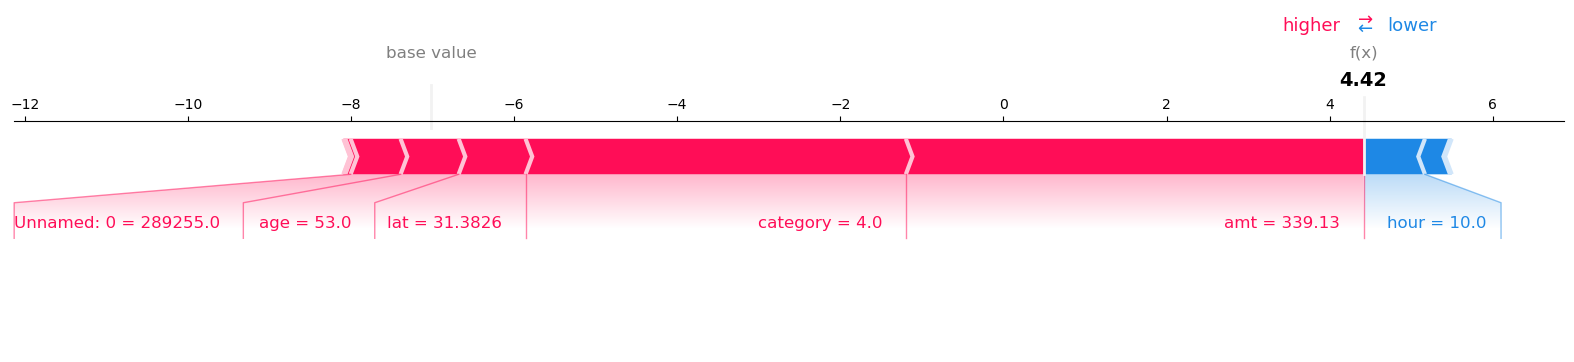


[INFO] Propagating updated model to distributed institutions securely...
[✔] Model update encrypted and transmitted
[✔] Remote institutions updated without accessing raw data (privacy preserved)


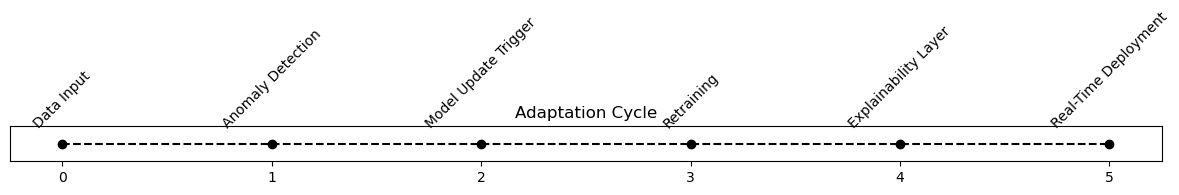

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import xgboost as xgb
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")

# === Load dataset ===
df = pd.read_csv("fraudTest.csv")

# === Feature Engineering ===

# Convert date columns
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['dob'] = pd.to_datetime(df['dob'])

# Compute user age at transaction time
df['age'] = (df['trans_date_trans_time'] - df['dob']).dt.days // 365

# Time of transaction (hour of day, could reveal behavior patterns)
df['hour'] = df['trans_date_trans_time'].dt.hour

# Distance between user and merchant (geo-aware fraud detection)
df['distance'] = np.sqrt((df['lat'] - df['merch_lat'])**2 + (df['long'] - df['merch_long'])**2)

# Drop unneeded columns for modeling
drop_cols = [
    'cc_num', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
    'trans_date_trans_time', 'dob', 'trans_num', 'unix_time',
    'merchant', 'job'
]
df = df.drop(columns=drop_cols)

# Encode categorical features
cat_cols = ['category']
df[cat_cols] = df[cat_cols].apply(LabelEncoder().fit_transform)

# Define features and target
X = df.drop('is_fraud', axis=1)
y = df['is_fraud']

# === Train initial XGBoost model ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("=== Initial Model Performance ===")
print(classification_report(y_test, y_pred))

# === Trigger: Low-amount purchases from young users (<30) ===
trigger_df = df[(df['amt'] < 50) & (df['age'] < 30)]

# === Anomaly detection with Isolation Forest ===
iso_model = IsolationForest(contamination=0.02, random_state=42)
iso_features = trigger_df.drop(columns='is_fraud')
iso_preds = iso_model.fit_predict(iso_features)

anomalies = trigger_df[iso_preds == -1]
print(f"\n[INFO] Detected {len(anomalies)} anomalies using Isolation Forest.")

# === Combine anomalies into training set ===
adaptive_df = pd.concat([df, anomalies])
adaptive_X = adaptive_df.drop('is_fraud', axis=1)
adaptive_y = adaptive_df['is_fraud']

xgb_adaptive = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_adaptive.fit(adaptive_X, adaptive_y)

# === Adjust threshold for higher fraud sensitivity ===
y_prob = xgb_adaptive.predict_proba(X_test)[:, 1]
y_new_pred = (y_prob > 0.35).astype(int)

print("\n=== Adapted Model Performance with Lower Threshold ===")
print(classification_report(y_test, y_new_pred))

# === Explainability with SHAP ===
print("\n[INFO] SHAP explanation for a flagged fraud case:")
explainer = shap.Explainer(xgb_adaptive)
shap_values = explainer(X_test)

fraud_index = np.where(y_new_pred == 1)[0][0]
shap.initjs()
shap.plots.force(shap_values[fraud_index], matplotlib=True)

# === Federated Learning Simulation Log ===
def simulate_federated_update():
    print("\n[INFO] Propagating updated model to distributed institutions securely...")
    print("[✔] Model update encrypted and transmitted")
    print("[✔] Remote institutions updated without accessing raw data (privacy preserved)")

simulate_federated_update()

# === Adaptation Cycle Visualization ===
def plot_adaptation_cycle():
    stages = [
        "Data Input", "Anomaly Detection", "Model Update Trigger",
        "Retraining", "Explainability Layer", "Real-Time Deployment"
    ]
    values = list(range(len(stages)))
    plt.figure(figsize=(12, 2))
    plt.plot(values, [1]*len(stages), 'o--k')
    for i, stage in enumerate(stages):
        plt.text(i, 1.05, stage, rotation=45, ha='center')
    plt.yticks([])
    plt.title("Adaptation Cycle")
    plt.tight_layout()
    plt.show()

plot_adaptation_cycle()


✅ anomalies_1001.csv saved.


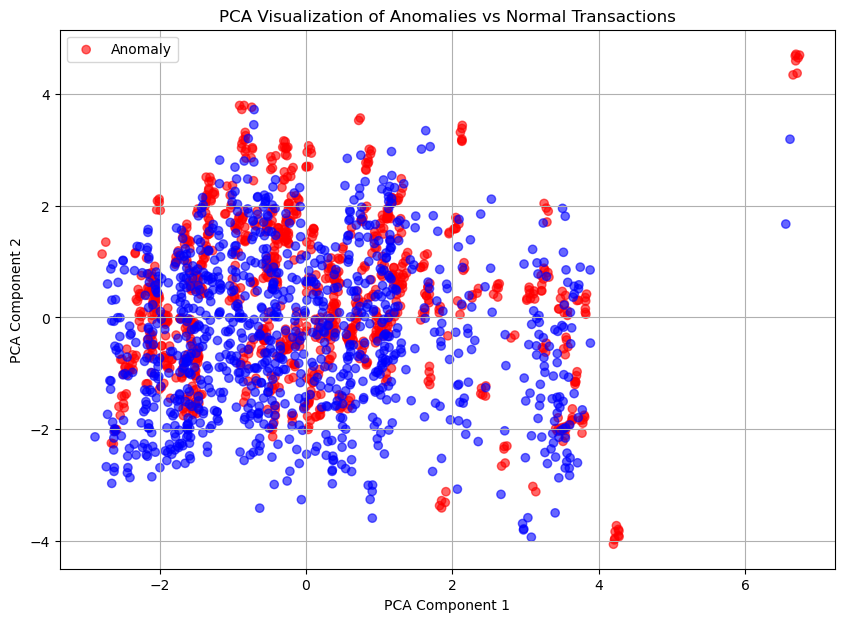

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Load your data (example file name)
df = pd.read_csv("fraudTest.csv")  # <-- change if needed

# Suppose 'is_fraud' column marks anomalies (1 for fraud, 0 for normal)
# Get 1001 anomaly records (adjust if needed)
anomalies_df = df[df['is_fraud'] == 1].sample(n=1001, random_state=42)

# Save 1001 anomalies to CSV
anomalies_df.to_csv("anomalies_1001.csv", index=False)
print("✅ anomalies_1001.csv saved.")

# Optional: concatenate with normal data to visualize comparison
normal_df = df[df['is_fraud'] == 0].sample(n=1001, random_state=1)
combined_df = pd.concat([anomalies_df, normal_df])

# Drop non-numeric or unnecessary columns
cols_to_use = combined_df.select_dtypes(include=[np.number]).columns.tolist()
X = combined_df[cols_to_use]

# Normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA (2D)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot
plt.figure(figsize=(10, 7))
labels = ['Anomaly' if i < 1001 else 'Normal' for i in range(len(combined_df))]
colors = ['red' if i < 1001 else 'blue' for i in range(len(combined_df))]

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=colors, alpha=0.6, label=labels)
plt.title("PCA Visualization of Anomalies vs Normal Transactions")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(["Anomaly", "Normal"])
plt.grid(True)
plt.show()
